<a href="https://colab.research.google.com/github/adimyth/datascience_stuff/blob/master/machine-learning/VariationalAutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Modelling

**Resources**
* [Jeremy Jordan's Blog](https://www.jeremyjordan.me/variational-autoencoders/)
* [Medium Blog](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
* [Tensorflow CVAE Tutorial](https://www.tensorflow.org/tutorials/generative/cvae)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D
from tensorflow.keras.layers import Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import fashion_mnist
from tqdm.notebook import tqdm

In [0]:
sns.set_style("darkgrid")

In [0]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [0]:
X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)

In [0]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

In [6]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [7]:
X_test.shape, y_test.shape 

((10000, 784), (10000,))

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# AutoEncoder

## AutoEncoders
In general AutoEncoders, the Encoder converts input data into an *encoding vector where each dimension represents some learned attribute about the data*. It outputs a *single value* for each dimension.

For a latent vector of dimension 6, autoencoder will learn descriptive attributes of faces such as skin color, whether or not the person is wearing glasses, etc. in an attempt to describe an observation in some compressed representation.

![AutoEncoder](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-16-at-10.24.11-PM.png)



In [0]:
def plot(X, title=""):
    h, w = 5, 5
    f = plt.figure(figsize=(6, 6))
    gs = f.add_gridspec(h, w)
    f.suptitle(title, fontsize=20)

    for i in range(h):
        for j in range(w):
            ax = f.add_subplot(gs[i, j])
            plt.imshow(X[i*h+j].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    f.tight_layout(rect=[0, 0.03, 1, 0.9])

In [0]:
input_img = Input(shape=(784,))
# ENCODER
encoder = Dense(512, activation="relu")(input_img)
encoder = Dense(128, activation="relu")(encoder)
# BottleNeck
bottleneck = Dense(2, activation='linear')(encoder)
# DECODER
decoder = Dense(128, activation="relu")(bottleneck)
decoder = Dense(512, activation="relu")(bottleneck)
decoder = Dense(784, activation='sigmoid')(decoder)

In [0]:
autoencoder = Model(input_img, decoder)

In [0]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=256,
                shuffle=True)

Epoch 1/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0543
Epoch 2/10
235/235 [==============================] - 6s 28ms/step - loss: 0.0360
Epoch 3/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0337
Epoch 4/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0326
Epoch 5/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0319
Epoch 6/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0312
Epoch 7/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0304
Epoch 8/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0297
Epoch 9/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0292
Epoch 10/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0287


In [0]:
X_test_autoencoder = autoencoder.predict(X_test)

**Reconstruction on Test Image**

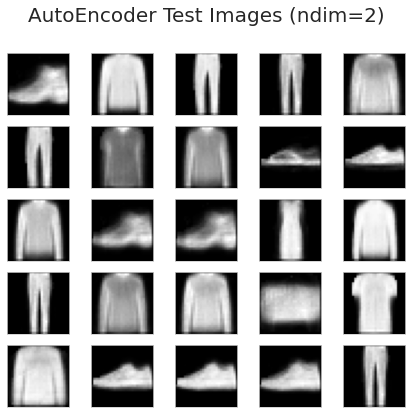

In [15]:
plot(X_test_autoencoder, f"AutoEncoder Test Images (ndim={2})")

## Latent Space Visualization

In [0]:
encoder = Model(input_img, bottleneck)

In [0]:
X_latent_autoencoder = encoder(X_test)

In [0]:
df = pd.DataFrame(X_latent_autoencoder.numpy(), columns=["Dim1", "Dim2"])
df["Value"] = [class_names[i] for i in y_test]

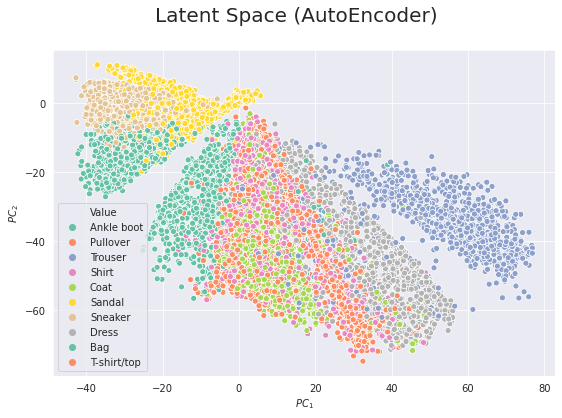

In [37]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.scatterplot(x="Dim1", y="Dim2", hue="Value", legend="full", palette="Set2", data=df)
ax.set_xlabel('$PC_1$')
ax.set_ylabel('$PC_2$')
fig.suptitle("Latent Space (AutoEncoder)", fontsize=20)
plt.show()

***The latent space are not continous in nature, hence we cannot interpolate & choose vectors at will.***

Visualizing the encodings from a 2D latent space reveals the formation of distinct clusters. This makes sense, as distinct encodings for each image type makes it far easier for the decoder to decode them.

To generate variations on input space, we would want to randomly sample from a continous latent space.

>If the space has discontinuities (eg. gaps between clusters) and you sample/generate a variation from there, the decoder will simply generate an unrealistic output, because the decoder has no idea how to deal with that region of the latent space. 

# Variational AutoEncoder

VAEs allow us to generate random, new output that looks similar to the training data.

VAEs provide a probabilistic distribution for describing each attribute/feature in the latent space. Instead of describing the input using a single variable, they represent each latent variable as a range of possible values described using a probability distribution. VAEs have latent spaces that are continous, allowing easy random sampling and interpolation.

![VAE](https://www.jeremyjordan.me/content/images/2018/06/Screen-Shot-2018-06-20-at-2.47.56-PM.png)

When decoding, we randomly sample from each latent state distribution to generate vector as input for the decoder model.

For any sampling of the latent distributions, we're expecting our decoder model to be able to accurately reconstruct the input i.e for nearby values for each featurer in the latent space distribution, shoule produce similar reconstructions.

![Sampled Decoding](https://www.jeremyjordan.me/content/images/2018/06/Screen-Shot-2018-06-20-at-2.48.42-PM.png)


## Encoder
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$.



## Decoder
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample  as input and outputs the parameters for a conditional distribution $p(z)$ of the observation.
$p(z)$ is unit gaussian distribution.

In [0]:
class CVAE(tf.keras.Model):
    
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([Input(shape=(28, 28, 1)),
                                    Conv2D(32, (3, 3), strides=(2, 2), activation='relu'),
                                    Conv2D(64, (3, 3), strides=(2, 2), activation='relu'), #7x7
                                    Flatten(),
                                    # mean, logvariance
                                    Dense(latent_dim + latent_dim)])

                                # μ + σ ⊙ ε
        self.decoder = Sequential([Input(shape=(latent_dim,)),
                                   Dense(units=7*7*32, activation="relu"),
                                   Reshape(target_shape=(7, 7, 32)),
                                   Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'),
                                   Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),
                                   Conv2DTranspose(1, (3, 3), strides=1, padding='same')])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## Log Normal PDF

\begin{align}
\ln\left(\frac{1}{\sigma \sqrt {2\pi}}
e^{-\frac{\left(x - \mu\right)^2}{2\sigma ^2}}\right) &= 
\ln\left(\frac {1}{\sigma \sqrt {2\pi}}\right)+\ln{\left(e^{-\frac {(x - \mu)^2}{2\sigma ^2}}\right)} \tag{3} \\[5px]
&=-\ln\left(\sigma\right)-\frac{1}{2} \ln\left(2\pi\right) - \frac{\left(x - \mu\right)^2}{2\sigma ^2} \tag{4}
\end{align}

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.*np.pi)
    return tf.reduce_sum(-.5*((sample - mean)**2.*tf.exp(-logvar)+logvar+log2pi),
      axis=raxis)

# log p(x|z) + log p(z) - log q(z|X)
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Since, we are using ***cross entropy loss***

In [0]:
X_train = np.where(X_train > .5, 1.0, 0.0).astype('float32')
X_test = np.where(X_test > .5, 1.0, 0.0).astype('float32')

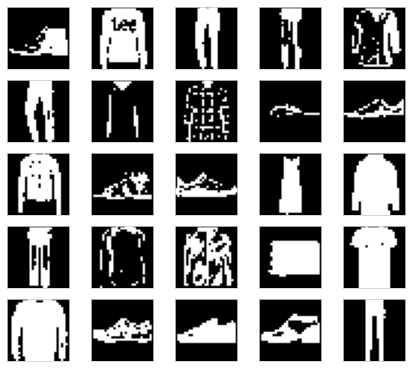

In [23]:
plot(X_test)

In [0]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

In [0]:
epochs = 10
latent_dim = 2
num_samples = 16
batch_size = 256

In [0]:
# 16x2
random_vector_for_generation = tf.random.normal(shape=[num_samples, latent_dim])
model = CVAE(latent_dim)

In [0]:
test_sample = X_test[0:num_samples, :, :, :]

In [0]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(7, 7))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.title(class_names[y_test[i]])
        plt.axis('off')

    fig.suptitle(f'Epoch_{epoch}', fontsize=20)
    plt.show()


Epoch: 1, Test set ELBO: -367.2646179199219


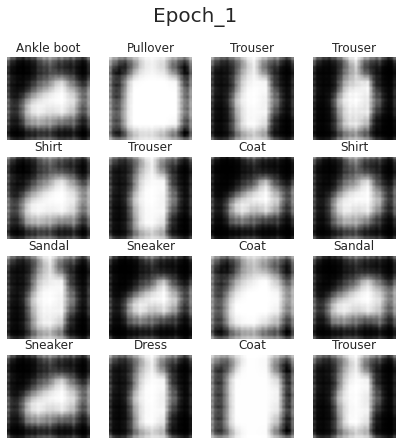


Epoch: 2, Test set ELBO: -309.00628662109375


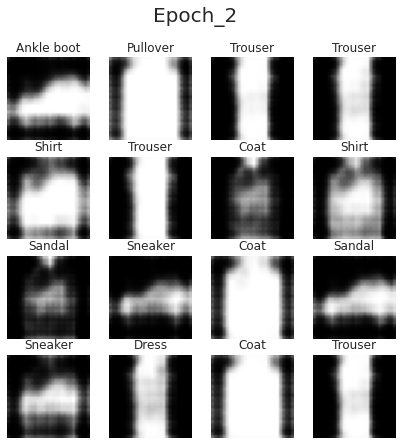


Epoch: 3, Test set ELBO: -277.7054138183594


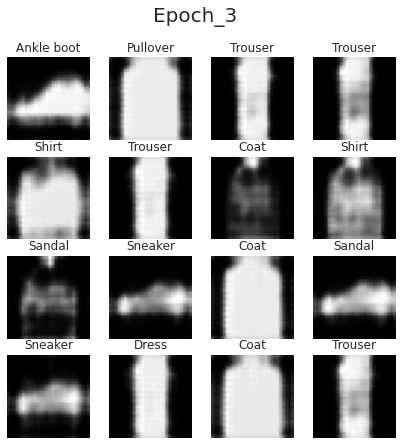


Epoch: 4, Test set ELBO: -237.6485137939453


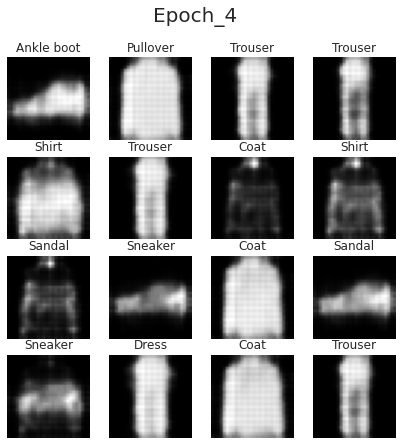


Epoch: 5, Test set ELBO: -225.0504913330078


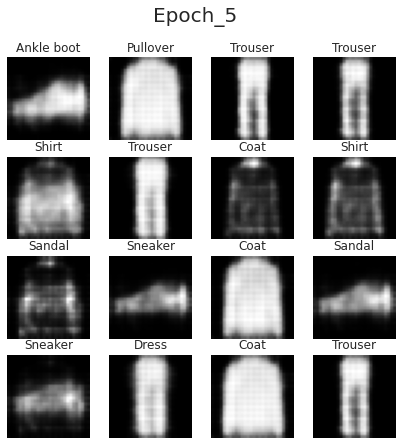


Epoch: 6, Test set ELBO: -219.651123046875


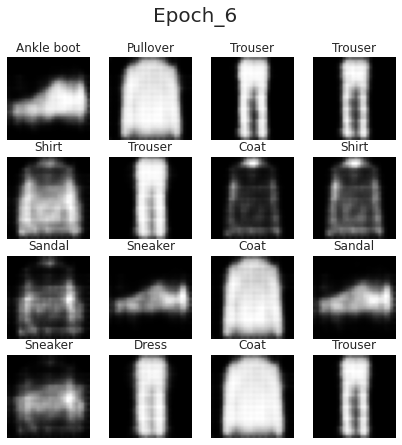


Epoch: 7, Test set ELBO: -216.0081329345703


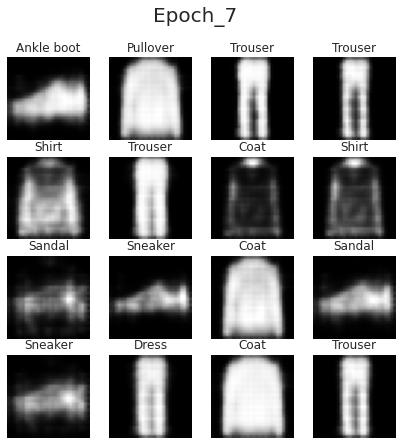


Epoch: 8, Test set ELBO: -213.2061309814453


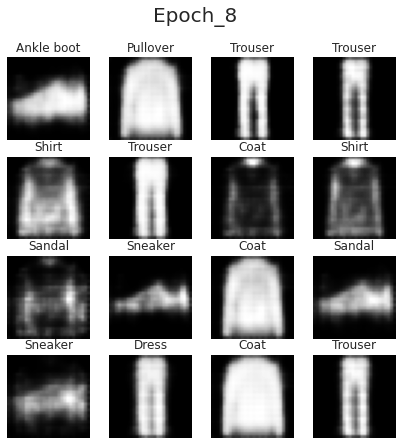


Epoch: 9, Test set ELBO: -211.0296630859375


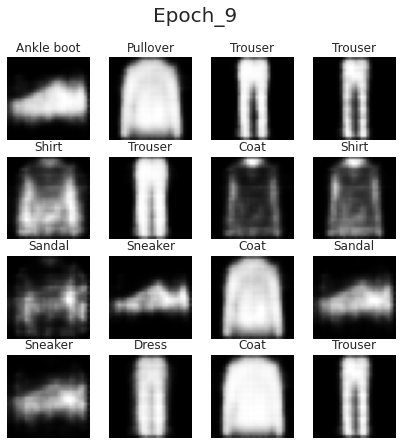


Epoch: 10, Test set ELBO: -209.3130645751953


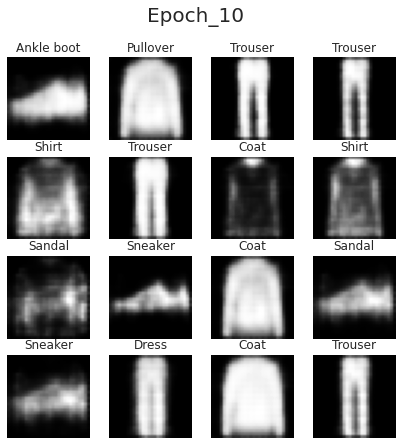

In [29]:
for epoch in range(1, epochs+1):
    for j in tqdm(range(0, X_train.shape[0], batch_size)):
        train_step(model, X_train[j:j+batch_size], optimizer)

    loss = tf.keras.metrics.Mean()
    for j in tqdm(range(0, X_test.shape[0], batch_size)):
        loss(compute_loss(model, X_test[j:j+batch_size]))
    elbo = -loss.result()
    print(f'Epoch: {epoch}, Test set ELBO: {elbo}')
    generate_and_save_images(model, epoch, test_sample)

## Latent Space Visualization

In [0]:
mean, logvar = model.encode(X_test)

In [0]:
X_latent_autoencoder = model.reparameterize(mean, logvar)

In [32]:
X_latent_autoencoder.shape

TensorShape([10000, 2])

In [0]:
df1 = pd.DataFrame(X_latent_autoencoder.numpy(), columns=["Dim1", "Dim2"])
df1["Value"] = [class_names[i] for i in y_test]

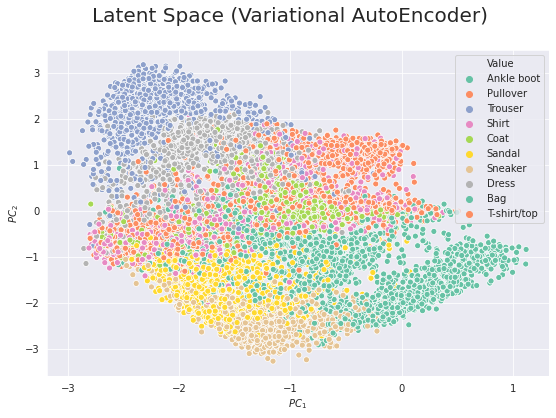

In [38]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.scatterplot(x="Dim1", y="Dim2", hue="Value", legend="full", palette="Set2", data=df1)
ax.set_xlabel('$PC_1$')
ax.set_ylabel('$PC_2$')
fig.suptitle("Latent Space (Variational AutoEncoder)", fontsize=20)
plt.show()

The *latent space* is continous as well as has capacity to segregate classes